Sklearn (全称 Scikit-Learn) 是基于 Python 语言的机器学习工具。它建立在 NumPy, SciPy, Pandas 和 Matplotlib 之上，里面的 API 的设计非常好，所有对象的接口简单，很适合新手上路。

足球比赛涉及的因素非常繁多，我无法将所有因素都融入机器学习模型中。本文只是一个黑客想用数据尝试一些很酷的东西。本文的目标是：

用机器学习来预测谁将赢得2022 FIFA世界杯的冠军；

预测整个比赛的小组赛结果；

模拟四分之一决赛、半决赛以及决赛。

这些目标代表了独一无二的现实世界里机器学习的预测问题，并将解决机器学习中的各种任务：数据集成、特征建模和结果预测。

首先，我们要针对两个数据集做探索性分析，然后经过特征工程来选择与预测关联性最强的特征，还有数据处理，再选择一个机器学习模型，最后将模型配置到数据集上。

首先，导入所需的代码库，并将数据集加载到数据框中：

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

导入数据集：

In [ ]:
world_cup = pd.read_csv('datasets/2022_world_cup_matches.csv ')
results = pd.read_csv('results.csv')

下一步是加载数据集。通过调用 world_cup.head() 和 results.head() ，务必将两个数据集都加载到数据框中，如下所示：

In [3]:
world_cup

,ID,Year,Date,Stage,Home Team,Away Team,Host Team
0,1,2022,2022/11/20,Group stage,卡塔尔,厄瓜多尔,True
1,2,2022,2022/11/21,Group stage,塞内加尔,荷兰,False
2,3,2022,2022/11/21,Group stage,英格兰,伊朗,False
3,4,2022,2022/11/21,Group stage,美国,威尔士,False
4,5,2022,2022/11/22,Group stage,法国,澳大利亚,False
...,...,...,...,...,...,...,...
59,60,2022,2022/12/10,Quarter-finals,W55,W56,NaN
60,61,2022,2022/12/13,Semi-finals,W57,W58,NaN
61,62,2022,2022/12/14,Semi-finals,W59,W60,NaN
62,63,2022,2022/12/17,Third place,L61,L62,NaN


In [4]:
results.head()      # 读取5行数据

,date,home_team,away_team,home_score,away_score
0,1970-01-04,Malta,Luxembourg,1,1
1,1970-01-14,英格兰,荷兰,0,0
2,1970-01-28,Israel,荷兰,0,1
3,1970-02-04,Peru,Czechoslovakia,0,2
4,1970-02-06,喀麦隆,Ivory Coast,3,2


探索性分析和特征工程：需要建立与机器学习模型相关的特征，在任何数据科学的项目中，这部分工作都是最耗时的。

现在我们把目标差异和结果列添加到结果数据集：

In [5]:
# Adding goal difference and establishing who is the winner
winner = []
for i in range (len(results['home_team'])):         # 主场遍历
     # 如果主场得分大于客场得分
    if results ['home_score'][i] > results['away_score'][i]:
        # 把主场国家添加到获胜列当中
        winner.append(results['home_team'][i])
        # 如果小于
    elif results['home_score'][i] < results ['away_score'][i]:
        # 把客场加进去
        winner.append(results['away_team'][i])
    else:
        # 相等则平局
        winner.append('Draw')

# 添加一列记录获胜情况
results['winning_team'] = winner

#adding goal difference column：求得分差
#np.absolute:求绝对值
results['goal_difference'] = np.absolute(results['home_score'] - results['away_score'])

'''检查一下新的结果数据框：'''
results.head()

,date,home_team,away_team,home_score,away_score,winning_team,goal_difference
0,1970-01-04,Malta,Luxembourg,1,1,Draw,0
1,1970-01-14,英格兰,荷兰,0,0,Draw,0
2,1970-01-28,Israel,荷兰,0,1,荷兰,1
3,1970-02-04,Peru,Czechoslovakia,0,2,Czechoslovakia,2
4,1970-02-06,喀麦隆,Ivory Coast,3,2,喀麦隆,1


然后我们着手处理仅包含输入的国家参加比赛的一组数据（这可以帮助我们集中找出哪些特征对一个国家有效，随后再扩展到参与世界杯的所有国家）：

In [6]:
# 定义一个DataFrame来接收Nation国家主场和客场的数据
Nation = input()
df = results[(results['home_team'] == Nation) | (results['away_team'] == Nation)]
Country = df.iloc[:]
Country.head()

,date,home_team,away_team,home_score,away_score,winning_team,goal_difference
85,1970-05-10,葡萄牙,意大利,1,2,意大利,1
226,1970-10-14,丹麦,葡萄牙,0,1,葡萄牙,1
331,1971-02-17,比利时,葡萄牙,3,0,比利时,3
355,1971-04-21,葡萄牙,Scotland,2,0,葡萄牙,2
385,1971-05-12,葡萄牙,丹麦,5,0,葡萄牙,5


过于久远的比赛对我们来说没有参考意义。我们为年份创建一列，并选择所有 1970 年之后举行的比赛：

In [7]:
year = []
for row in Country['date']:
    # 因为此时的row为1970-03-23，我们只需要前四个数字
    year.append(int(row[:4]))
print(len(year))
#添加match_year:比赛年份  用来筛选1970年后的比赛
Country ['match_year']= year

Country_1970 = Country[Country.match_year >= 1970]
Country_1970.count()        # count:一个数列中非na元素的个数。

437


date               437
home_team          437
away_team          437
home_score         437
away_score         437
winning_team       437
goal_difference    437
match_year         437
dtype: int64

In [8]:
Country_1970

,date,home_team,away_team,home_score,away_score,winning_team,goal_difference,match_year
85,1970-05-10,葡萄牙,意大利,1,2,意大利,1,1970
226,1970-10-14,丹麦,葡萄牙,0,1,葡萄牙,1,1970
331,1971-02-17,比利时,葡萄牙,3,0,比利时,3,1971
355,1971-04-21,葡萄牙,Scotland,2,0,葡萄牙,2,1971
385,1971-05-12,葡萄牙,丹麦,5,0,葡萄牙,5,1971
...,...,...,...,...,...,...,...,...
31293,2017-10-10,葡萄牙,瑞士,2,0,葡萄牙,2,2017
31330,2017-11-10,葡萄牙,沙特阿拉伯,3,0,葡萄牙,3,2017
31392,2017-11-14,葡萄牙,美国,1,1,Draw,0,2017
31513,2018-03-23,葡萄牙,Egypt,2,1,葡萄牙,1,2018


现在我们可以用图形表示这些年来表示输入国家的最普遍的比赛结果：

<AxesSubplot:xlabel='Country_Results', ylabel='count'>

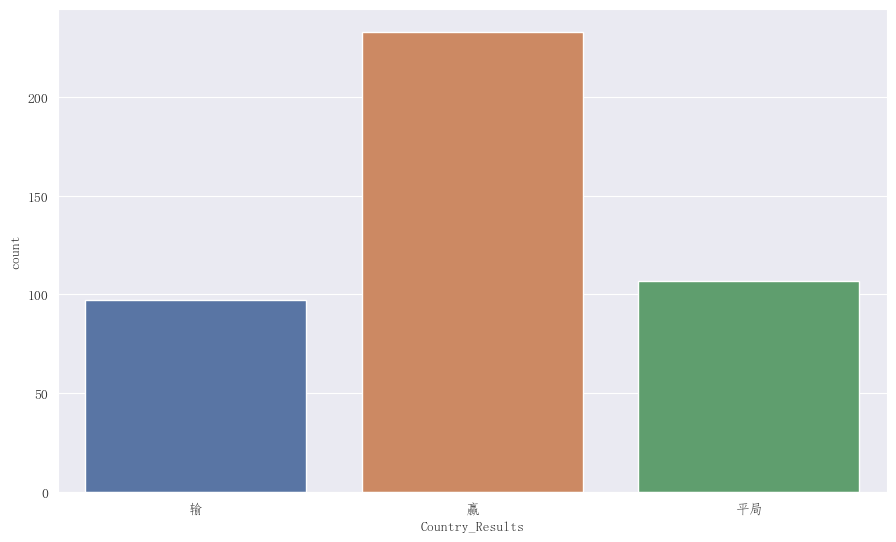

In [9]:
#what is the common game outcome for nigeria visualisation
wins = []
# 遍历（winning_team)获胜队伍列
for row in Country_1970['winning_team']:
    #如果获胜者是不是Nigeria和不是平局判定为输
    #即把输的从国家改为loss
    if row != Nation and row != 'Draw':
        wins.append('输')     #判定为输，平局不算输
    elif row == 'Draw':
        wins.append('平局')        # 把平局和获胜加进去
    else:
        wins.append("赢")
winsdf= pd.DataFrame(wins, columns=[ 'Country_Results'])

'''用图显示出来'''
#plotting
plt.rc("font", family='FangSong')
fig, ax = plt.subplots(1)
fig.set_size_inches(10.7, 6.27)
sns.set(style='darkgrid')
# sns.set_style("whitegrid")
sns.countplot(x='Country_Results', data=winsdf)

In [10]:
winsdf

,Country_Results
0,输
1,赢
2,输
3,赢
4,赢
...,...
432,赢
433,赢
434,平局
435,赢


In [11]:
'''
获胜是分析和预测比赛结果的一个很好的指标
比赛和场地对我们的预测没有多大影响
将使用历史匹配记录
'''

'\n获胜是分析和预测比赛结果的一个很好的指标\n比赛和场地对我们的预测没有多大影响\n将使用历史匹配记录\n'

我们为2022世界杯所有参赛队伍创建一个数据框，然后从该数据框中进一步筛选出从 1970 年起参加世界杯的队伍，并去掉重复的队伍：

In [12]:
results

,date,home_team,away_team,home_score,away_score,winning_team,goal_difference
0,1970-01-04,Malta,Luxembourg,1,1,Draw,0
1,1970-01-14,英格兰,荷兰,0,0,Draw,0
2,1970-01-28,Israel,荷兰,0,1,荷兰,1
3,1970-02-04,Peru,Czechoslovakia,0,2,Czechoslovakia,2
4,1970-02-06,喀麦隆,Ivory Coast,3,2,喀麦隆,1
...,...,...,...,...,...,...,...
31617,2018-03-27,Mongolia,Mauritius,0,2,Mauritius,2
31618,2018-03-27,Seychelles,Swaziland,0,0,Draw,0
31619,2018-03-27,Kosovo,Burkina Faso,2,0,Kosovo,2
31620,2018-03-27,Iraq,Syria,1,1,Draw,0


In [13]:
#narrowing to team patcipating in the world cup
worldcup_teams = ['卡塔尔','厄瓜多尔','塞内加尔','荷兰',
            '英格兰','伊朗','美国','威尔士',
            '阿根廷', '沙特阿拉伯', '墨西哥', '波兰',
            '法国', '澳大利亚', '丹麦', '突尼斯',
            '西班牙', '哥斯达黎加', '德国', '日本',
            '比利时', '加拿大', '摩洛哥', '克罗地亚',
            '巴西', '塞尔维亚', '瑞士', '喀麦隆',
            '葡萄牙', '加纳', '乌拉圭', '韩国']

#主场（看世界杯队伍在不在results数据集中）
df_teams_home = results[results['home_team'].isin(worldcup_teams)]
#客场
df_teams_away = results[results['away_team'].isin(worldcup_teams)]

主场是世界杯参赛国家的情况

In [14]:
df_teams_home

,date,home_team,away_team,home_score,away_score,winning_team,goal_difference
1,1970-01-14,英格兰,荷兰,0,0,Draw,0
4,1970-02-06,喀麦隆,Ivory Coast,3,2,喀麦隆,1
9,1970-02-08,喀麦隆,Ethiopia,3,2,喀麦隆,1
17,1970-02-11,加纳,Guinea,1,1,Draw,0
18,1970-02-11,西班牙,德国,2,0,西班牙,2
...,...,...,...,...,...,...,...
31596,2018-03-27,丹麦,Chile,0,0,Draw,0
31598,2018-03-27,比利时,沙特阿拉伯,4,0,比利时,4
31605,2018-03-27,突尼斯,哥斯达黎加,1,0,突尼斯,1
31607,2018-03-27,波兰,韩国,3,2,波兰,1



客场是世界杯参赛国家的情况

In [15]:
df_teams_away

,date,home_team,away_team,home_score,away_score,winning_team,goal_difference
1,1970-01-14,英格兰,荷兰,0,0,Draw,0
2,1970-01-28,Israel,荷兰,0,1,荷兰,1
6,1970-02-07,Congo DR,加纳,0,2,加纳,2
12,1970-02-09,Egypt,加纳,1,1,Draw,0
15,1970-02-10,Sudan,喀麦隆,2,1,Sudan,1
...,...,...,...,...,...,...,...
31598,2018-03-27,比利时,沙特阿拉伯,4,0,比利时,4
31599,2018-03-27,Algeria,伊朗,1,2,伊朗,1
31601,2018-03-27,Bosnia-Herzegovina,塞内加尔,0,0,Draw,0
31605,2018-03-27,突尼斯,哥斯达黎加,1,0,突尼斯,1


In [16]:
df_teams = pd.concat((df_teams_home, df_teams_away))        # 数据合并
df_teams

,date,home_team,away_team,home_score,away_score,winning_team,goal_difference
1,1970-01-14,英格兰,荷兰,0,0,Draw,0
4,1970-02-06,喀麦隆,Ivory Coast,3,2,喀麦隆,1
9,1970-02-08,喀麦隆,Ethiopia,3,2,喀麦隆,1
17,1970-02-11,加纳,Guinea,1,1,Draw,0
18,1970-02-11,西班牙,德国,2,0,西班牙,2
...,...,...,...,...,...,...,...
31598,2018-03-27,比利时,沙特阿拉伯,4,0,比利时,4
31599,2018-03-27,Algeria,伊朗,1,2,伊朗,1
31601,2018-03-27,Bosnia-Herzegovina,塞内加尔,0,0,Draw,0
31605,2018-03-27,突尼斯,哥斯达黎加,1,0,突尼斯,1


In [17]:
df_teams.drop_duplicates()          # 去掉重复的
df_teams

,date,home_team,away_team,home_score,away_score,winning_team,goal_difference
1,1970-01-14,英格兰,荷兰,0,0,Draw,0
4,1970-02-06,喀麦隆,Ivory Coast,3,2,喀麦隆,1
9,1970-02-08,喀麦隆,Ethiopia,3,2,喀麦隆,1
17,1970-02-11,加纳,Guinea,1,1,Draw,0
18,1970-02-11,西班牙,德国,2,0,西班牙,2
...,...,...,...,...,...,...,...
31598,2018-03-27,比利时,沙特阿拉伯,4,0,比利时,4
31599,2018-03-27,Algeria,伊朗,1,2,伊朗,1
31601,2018-03-27,Bosnia-Herzegovina,塞内加尔,0,0,Draw,0
31605,2018-03-27,突尼斯,哥斯达黎加,1,0,突尼斯,1


In [18]:
df_teams.count()        # 统计数量

date               15540
home_team          15540
away_team          15540
home_score         15540
away_score         15540
winning_team       15540
goal_difference    15540
dtype: int64

In [19]:
df_teams.head()

,date,home_team,away_team,home_score,away_score,winning_team,goal_difference
1,1970-01-14,英格兰,荷兰,0,0,Draw,0
4,1970-02-06,喀麦隆,Ivory Coast,3,2,喀麦隆,1
9,1970-02-08,喀麦隆,Ethiopia,3,2,喀麦隆,1
17,1970-02-11,加纳,Guinea,1,1,Draw,0
18,1970-02-11,西班牙,德国,2,0,西班牙,2


为年份创建一列，去掉 1970 年之前的比赛（年份久远没没有参考性），并去掉不会影响到比赛结果的数据列，比如 date（日期）、home_score（主场得分）、away_score（客场得分）、tournament（锦标赛）、city（城市）、country（国家）、goal_difference（目标差异）和 match_year（比赛年份）：

In [20]:
year = []
# 新加一列year，为date的前四个（即年份）
for row in df_teams['date']:
    year.append(int(row[:4]))
df_teams['match_year'] = year
# 只要1970年以后的数据
df_teams_1970 = df_teams[df_teams.match_year >= 1930]
df_teams_1970.head()

,date,home_team,away_team,home_score,away_score,winning_team,goal_difference,match_year
1,1970-01-14,英格兰,荷兰,0,0,Draw,0,1970
4,1970-02-06,喀麦隆,Ivory Coast,3,2,喀麦隆,1,1970
9,1970-02-08,喀麦隆,Ethiopia,3,2,喀麦隆,1,1970
17,1970-02-11,加纳,Guinea,1,1,Draw,0,1970
18,1970-02-11,西班牙,德国,2,0,西班牙,2,1970


In [21]:
# 删除data，home_score...列
df_teams_1970 = df_teams.drop(['date', 'home_score', 'away_score', 'goal_difference', 'match_year'], axis=1)       # 0-行 1-列
df_teams_1970.head()

,home_team,away_team,winning_team
1,英格兰,荷兰,Draw
4,喀麦隆,Ivory Coast,喀麦隆
9,喀麦隆,Ethiopia,喀麦隆
17,加纳,Guinea,Draw
18,西班牙,德国,西班牙


为了简化模型的处理，我们修改一下预测标签。

如果主场队伍获胜，那么 winning_team（获胜队伍）一列显示“2”，如果平局则显示“1”，如果是客场队伍获胜则显示“0”：

In [22]:
# 重置索引
df_teams_1970 = df_teams_1970.reset_index(drop=True)

# 如果主场和获胜的队伍一样，则将获胜队伍附为2
df_teams_1970.loc[df_teams_1970.winning_team == df_teams_1970.home_team,'winning_team']=2
# 平局则为1
df_teams_1970.loc[df_teams_1970.winning_team == 'Draw', 'winning_team']=1
# 客场胜利为0
df_teams_1970.loc[df_teams_1970.winning_team == df_teams_1970.away_team, 'winning_team']=0

df_teams_1970

,home_team,away_team,winning_team
0,英格兰,荷兰,1
1,喀麦隆,Ivory Coast,2
2,喀麦隆,Ethiopia,2
3,加纳,Guinea,1
4,西班牙,德国,2
...,...,...,...
15535,比利时,沙特阿拉伯,2
15536,Algeria,伊朗,0
15537,Bosnia-Herzegovina,塞内加尔,1
15538,突尼斯,哥斯达黎加,2


通过设置哑变量（dummy variables），我们将 home_team（主场队伍）和away _team（客场队伍）从分类变量转换成连续的输入。

这时可以使用 pandas 的 get_dummies() 函数，它会将分类列替换成一位有效值（one-hot，由数字‘1’和‘0’组成），以便将它们加载到 Scikit-learn 模型中。

接下来，我们将数据按照 70% 的训练数据集和 30% 的测试数据集分成 X 集和 Y 集：

In [23]:
'''
将主队和客队从分类变量转换为连续输入
获取虚拟变量
'''
final = pd.get_dummies(df_teams_1970, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Separate X and y sets
X = final.drop(['winning_team'], axis=1)
y = final["winning_team"]

In [24]:
final

,winning_team,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andorra,home_team_Angola,home_team_Antigua and Barbuda,home_team_Armenia,home_team_Austria,home_team_Azerbaijan,...,away_team_瑞典,away_team_瑞士,away_team_突尼斯,away_team_美国,away_team_英格兰,away_team_荷兰,away_team_葡萄牙,away_team_西班牙,away_team_阿根廷,away_team_韩国
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15535,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15536,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15537,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15538,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
X

,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andorra,home_team_Angola,home_team_Antigua and Barbuda,home_team_Armenia,home_team_Austria,home_team_Azerbaijan,home_team_Bahrain,...,away_team_瑞典,away_team_瑞士,away_team_突尼斯,away_team_美国,away_team_英格兰,away_team_荷兰,away_team_葡萄牙,away_team_西班牙,away_team_阿根廷,away_team_韩国
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15536,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
y

0        1
1        2
2        2
3        1
4        2
        ..
15535    2
15536    0
15537    1
15538    2
15539    2
Name: winning_team, Length: 15540, dtype: object

train_test_split方法能够将数据集按照用户的需要指定划分为训练集和测试集

In [27]:
y = y.astype('int')
# 分离训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [28]:
final.head()

,winning_team,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andorra,home_team_Angola,home_team_Antigua and Barbuda,home_team_Armenia,home_team_Austria,home_team_Azerbaijan,...,away_team_瑞典,away_team_瑞士,away_team_突尼斯,away_team_美国,away_team_英格兰,away_team_荷兰,away_team_葡萄牙,away_team_西班牙,away_team_阿根廷,away_team_韩国
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


这里我们将使用分类算法：逻辑回归。这个算法的工作原理是什么？该算法利用逻辑函数来预测概率，从而可以测量出分类因变量与一个或多个自变量之间的关系。具体来说就是累积的逻辑分布。

换句话说，逻辑回归可以针对一组可以影响到结果的既定数据集（统计值）尝试预测结果（赢或输）。

在实践中这种方法的工作原理是：使用上述的两套“数据集”和比赛的实际结果，一次输入一场比赛到算法中。然后模型就会学习输入的每条数据对比赛结果产生了积极的效果还是消极的效果，以及影响的程度。

经过充分的（好）数据的训练后，就可以得到能够预测未来结果的模型，而模型的好坏程度取决于输入的数据。

之后我们将这些数据传递到算法中：

逻辑回归是一个非常经典的算法，用于解决分类问题的机器学习方法，用于估计某种事物的可能性，其有着简单、可并行化、可解释强的特点。逻辑回归虽然被称为回归，实际上是分类模型，并常用于二分类。

逻辑回归训练后的模型是平面的一条直线（p=2),或是平面（p=3)，超平面（p>3)。并且这条线或平面把空间中的散点分成两半，属于同一类的数据大多数分布在曲线或平面的同一侧。

In [29]:
'''
fit(X, y, sample_weight=None)：拟合模型，用来训练LR分类器，其中X是训练样本，y是对应的标记向量
predict(X)：用来预测样本，也就是分类，X是测试集。返回array。
score(X, y, sample_weight=None) ：返回给定测试集合的平均准确率（mean accuracy），浮点型数值。 对于多个分类返回，则返回每个类别的准确率组成的哈希矩阵。R^2评估模型
'''

'\nfit(X, y, sample_weight=None)：拟合模型，用来训练LR分类器，其中X是训练样本，y是对应的标记向量\npredict(X)：用来预测样本，也就是分类，X是测试集。返回array。\nscore(X, y, sample_weight=None) ：返回给定测试集合的平均准确率（mean accuracy），浮点型数值。 对于多个分类返回，则返回每个类别的准确率组成的哈希矩阵。R^2评估模型\n'

In [30]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
score = logreg.score(X_train, y_train)
score2 = logreg.score(X_test, y_test)

print("Training set accuracy: ", '%.3f'%(score))
print("Test set accuracy: ", '%.3f'%(score2))

Training set accuracy:  0.583
Test set accuracy:  0.548


我们的模型子训练数据集的正确率为 58%，在测试数据集上的正确率为 54%。虽然结果不是很好，但是我们先继续下一步。

接下来我们建立需要配置到模型的数据框。

首先我们加载 2022 年 10 月 FIFA 排名数据和小组赛分组状况的数据集。由于世界杯比赛中没有“主场”和“客场”，所以我们把 FIFA 排名靠前的队伍作为“喜爱”的比赛队伍，将他们放到“home_teams”（主场队伍）一列。然后我们根据每个队伍的排名将他们加入到新的预测数据集中。下一步是创建默认变量，并部署机器学习模型。

In [31]:
'''
#添加国际足联排名
#在国际足联排名中排名靠前的球队将被认为是这场比赛的“热门”
#因此，将位于“home_teams”列下
#因为世界杯比赛中没有“主场”或“客场”球队
'''
'''加载新的数据集'''
ranking = pd.read_csv('datasets/fifa_ranking_2022.csv')             # 国际足联排名
fixtures = pd.read_csv('datasets/2022_world_cup_matches.csv')
# 固定小组

'''存储小组赛的列表'''
pred_set = []

In [32]:
fixtures

,ID,Year,Date,Stage,Home Team,Away Team,Host Team
0,1,2022,2022/11/20,Group stage,卡塔尔,厄瓜多尔,True
1,2,2022,2022/11/21,Group stage,塞内加尔,荷兰,False
2,3,2022,2022/11/21,Group stage,英格兰,伊朗,False
3,4,2022,2022/11/21,Group stage,美国,威尔士,False
4,5,2022,2022/11/22,Group stage,法国,澳大利亚,False
...,...,...,...,...,...,...,...
59,60,2022,2022/12/10,Quarter-finals,W55,W56,NaN
60,61,2022,2022/12/13,Semi-finals,W57,W58,NaN
61,62,2022,2022/12/14,Semi-finals,W59,W60,NaN
62,63,2022,2022/12/17,Third place,L61,L62,NaN


pandas提供了使用insert函数使得我们可以在任意位置添加新列。
我们需要通过传递索引作为第一个参数来指定位置。此值必须是整数。列索引从零开始，就像行索引一样，第二个参数是列名，第三个参数是对象，这些对象可以是Series或数组。

set_index 仅适用于 DataFrame, 作用是重新设置 DataFrame 的行索引

map()函数可以用于Series对象或DataFrame对象的一列，接收函数作为或字典对象作为参数，返回经过函数或字典映射处理后的值

In [33]:
'''创建包含每个团队排名位置的新列'''
# 给fixtures添加第1列，名字为home_team_rank，内容是与fixtures的home team对应的ranking的Position
fixtures.insert(1, 'home_team_rank', fixtures['Home Team'].map(ranking.set_index('Team')['Position']))
# 给fixtures添加第1列，名字为away_team_rank，内容是与fixtures的away team对应的ranking的Position
fixtures.insert(2, 'away_team_rank', fixtures['Away Team'].map(ranking.set_index('Team')['Position']))

'''我们只需要小组赛，所以要对数据集进行切片'''
fixtures = fixtures.iloc[:48, :]            # 前48场为小组赛

fixtures

,ID,home_team_rank,away_team_rank,Year,Date,Stage,Home Team,Away Team,Host Team
0,1,50.0,44.0,2022,2022/11/20,Group stage,卡塔尔,厄瓜多尔,True
1,2,18.0,8.0,2022,2022/11/21,Group stage,塞内加尔,荷兰,False
2,3,5.0,20.0,2022,2022/11/21,Group stage,英格兰,伊朗,False
3,4,16.0,19.0,2022,2022/11/21,Group stage,美国,威尔士,False
4,5,4.0,38.0,2022,2022/11/22,Group stage,法国,澳大利亚,False
5,6,10.0,30.0,2022,2022/11/22,Group stage,丹麦,突尼斯,False
6,7,13.0,26.0,2022,2022/11/22,Group stage,墨西哥,波兰,False
7,8,3.0,51.0,2022,2022/11/22,Group stage,阿根廷,沙特阿拉伯,False
8,9,2.0,41.0,2022,2022/11/23,Group stage,比利时,加拿大,False
9,10,7.0,31.0,2022,2022/11/23,Group stage,西班牙,哥斯达黎加,False


In [34]:
'''循环以根据每个团队的排名位置将团队添加到新的预测数据集'''
for index, row in fixtures.iterrows():
    if row['home_team_rank'] < row['away_team_rank']:
        pred_set.append({'home_team': row['Home Team'], 'away_team': row['Away Team'], 'winning_team': None})
    else:
        pred_set.append({'home_team': row['Away Team'], 'away_team': row['Home Team'], 'winning_team': None})
        
pred_set = pd.DataFrame(pred_set)
backup_pred_set = pred_set

pred_set.head()

,home_team,away_team,winning_team
0,厄瓜多尔,卡塔尔,None
1,荷兰,塞内加尔,None
2,英格兰,伊朗,None
3,美国,威尔士,None
4,法国,澳大利亚,None


In [35]:
'''获取虚拟变量并删除winning_team列'''
pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

pred_set

,winning_team,home_team_丹麦,home_team_乌拉圭,home_team_克罗地亚,home_team_厄瓜多尔,home_team_塞内加尔,home_team_塞尔维亚,home_team_墨西哥,home_team_威尔士,home_team_巴西,...,away_team_德国,away_team_摩洛哥,away_team_日本,away_team_沙特阿拉伯,away_team_波兰,away_team_澳大利亚,away_team_瑞士,away_team_突尼斯,away_team_美国,away_team_韩国
0,None,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,None,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,None,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,None,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,None,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,None,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,None,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
7,None,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,None,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,None,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
'''添加与模型的集训练数据相比缺少的列'''
missing_cols = set(final.columns) - set(pred_set.columns)
for c in missing_cols:
    pred_set[c] = 0
pred_set = pred_set[final.columns]

'''删除获胜团队列'''
pred_set = pred_set.drop(['winning_team'], axis=1)

pred_set.head()

,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andorra,home_team_Angola,home_team_Antigua and Barbuda,home_team_Armenia,home_team_Austria,home_team_Azerbaijan,home_team_Bahrain,...,away_team_瑞典,away_team_瑞士,away_team_突尼斯,away_team_美国,away_team_英格兰,away_team_荷兰,away_team_葡萄牙,away_team_西班牙,away_team_阿根廷,away_team_韩国
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


比赛结果预测

首先，我们将模型部署到小组赛中：

predict返回的是一个预测的值，predict_proba返回的是对于预测为各个类别的概率。predict_proba返回的是一个 n 行 k 列的数组， 第 i 行 j列的数值是模型预测 第 i 个预测样本为某个标签的概率，并且每一行的概率和为1。

In [ ]:
'''小组赛'''
predictions = logreg.predict(pred_set)
# print(predictions)
for i in range(fixtures.shape[0]):
    print(backup_pred_set.iloc[i, 1] + " 对 " + backup_pred_set.iloc[i, 0])
    if predictions[i] == 2:
        print("Winner: " + backup_pred_set.iloc[i, 0])
    elif predictions[i] == 1:
        print("Draw")
    elif predictions[i] == 0:
        print("Winner: " + backup_pred_set.iloc[i, 1])
    print(backup_pred_set.iloc[i, 1] + ' 胜： ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
    print('平局： ', '%.3f'%(logreg.predict_proba(pred_set)[i][1]))
    print(backup_pred_set.iloc[i, 0] + ' 胜：  ', '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
    print("")


In [38]:
'''之前的元组列表'''
group_16 = [('荷兰', '美国'),
            ('阿根廷', '澳大利亚'),
            ('日本', '克罗地亚'),
            ('英格兰', '塞内加尔'),
            ('法国', '波兰'),
            ('摩洛哥', '西班牙'),
            ('巴西', '韩国'),
            ('葡萄牙', '瑞士')]

之后进行16强的模拟：

In [39]:
def clean_and_predict(matches, ranking, final, logreg):

    '''数据清理辅助列表初始化'''
    positions = []

    '''循环以根据FIFA排名检索每个球队的位置'''
    for match in matches:
        positions.append(ranking.loc[ranking['Team'] == match[0],'Position'].iloc[0])
        positions.append(ranking.loc[ranking['Team'] == match[1],'Position'].iloc[0])

    '''创建预测数据表'''
    pred_set = []

    '''正在初始化while循环的迭代器'''
    i = 0
    j = 0

    '''“i”将是“位置”列表的迭代器，“j”将是匹配列表（元组列表）'''
    while i < len(positions):
        dict1 = {}

        '''如果第一队的位置更好，他将是“主队”，反之亦然'''
        if positions[i] < positions[i + 1]:
            dict1.update({'home_team': matches[j][0], 'away_team': matches[j][1]})
        else:
            dict1.update({'home_team': matches[j][1], 'away_team': matches[j][0]})

        '''将更新的字典追加到列表中，稍后将转换为DataFrame'''
        pred_set.append(dict1)
        i += 2
        j += 1

    '''将列表转换为DataFrame'''
    pred_set = pd.DataFrame(pred_set)
    backup_pred_set = pred_set

    '''获取虚拟变量并删除winning_team列'''
    pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

    '''添加与模型的训练数据集相比缺少的列'''
    missing_cols2 = set(final.columns) - set(pred_set.columns)
    for c in missing_cols2:
        pred_set[c] = 0
    pred_set = pred_set[final.columns]

    '''删除获胜团队列'''
    pred_set = pred_set.drop(['winning_team'], axis=1)

    '''预言'''
    predictions = logreg.predict(pred_set)
    for i in range(len(pred_set)):
        print(backup_pred_set.iloc[i, 1] + " 对 " + backup_pred_set.iloc[i, 0])
        if predictions[i] == 2:
            print("Winner: " + backup_pred_set.iloc[i, 0])
        elif predictions[i] == 1:
            print("Draw")
        elif predictions[i] == 0:
            print("获胜者： " + backup_pred_set.iloc[i, 1])
        print(backup_pred_set.iloc[i, 1] + ' 胜： ' , '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
        print('平局： ', '%.3f'%(logreg.predict_proba(pred_set)[i][1]))
        print(backup_pred_set.iloc[i, 0] + ' 胜： ', '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
        print("")

In [40]:
clean_and_predict(group_16, ranking, final, logreg)

美国 对 荷兰
Winner: 荷兰
美国 胜：  0.104
平局：  0.152
荷兰 胜：  0.744

澳大利亚 对 阿根廷
Winner: 阿根廷
澳大利亚 胜：  0.070
平局：  0.286
阿根廷 胜：  0.643

日本 对 克罗地亚
Winner: 克罗地亚
日本 胜：  0.186
平局：  0.196
克罗地亚 胜：  0.618

塞内加尔 对 英格兰
Winner: 英格兰
塞内加尔 胜：  0.074
平局：  0.233
英格兰 胜：  0.692

波兰 对 法国
Winner: 法国
波兰 胜：  0.187
平局：  0.246
法国 胜：  0.567

摩洛哥 对 西班牙
Winner: 西班牙
摩洛哥 胜：  0.112
平局：  0.220
西班牙 胜：  0.667

韩国 对 巴西
Winner: 巴西
韩国 胜：  0.068
平局：  0.189
巴西 胜：  0.742

瑞士 对 葡萄牙
Winner: 葡萄牙
瑞士 胜：  0.141
平局：  0.250
葡萄牙 胜：  0.609



之后依次进行四分之一、半决赛、决赛的模拟：

四分之一：

In [ ]:
# List of matches
# quarters = [('荷兰', '阿根廷'),
#             ('克罗地亚', '巴西'),
#             ('法国', '英格兰'),
#             ('西班牙', '葡萄牙')]
quarters = [('荷兰', '阿根廷'),
            ('克罗地亚', '巴西'),
            ('法国', '英格兰'),
            ('摩洛哥', '葡萄牙')]

In [42]:
clean_and_predict(quarters, ranking, final, logreg)

荷兰 对 阿根廷
Winner: 阿根廷
荷兰 胜：  0.235
平局：  0.312
阿根廷 胜：  0.453

克罗地亚 对 巴西
Winner: 巴西
克罗地亚 胜：  0.133
平局：  0.209
巴西 胜：  0.659

英格兰 对 法国
Winner: 法国
英格兰 胜：  0.272
平局：  0.354
法国 胜：  0.375

摩洛哥 对 葡萄牙
Winner: 葡萄牙
摩洛哥 胜：  0.124
平局：  0.314
葡萄牙 胜：  0.562



半决赛：

In [43]:
# List of matches
# semi = [('法国', '西班牙'),
#         ('阿根廷', '巴西')]
semi = [('法国', '葡萄牙'),
        ('阿根廷', '巴西')]

In [44]:
clean_and_predict(semi, ranking, final, logreg)

葡萄牙 对 法国
Winner: 法国
葡萄牙 胜：  0.240
平局：  0.263
法国 胜：  0.497

阿根廷 对 巴西
Winner: 巴西
阿根廷 胜：  0.169
平局：  0.264
巴西 胜：  0.567



决赛：

In [45]:
# Finals
finals = [('巴西', '法国')]

In [46]:
clean_and_predict(finals, ranking, final, logreg)

法国 对 巴西
Winner: 巴西
法国 胜：  0.237
平局：  0.254
巴西 胜：  0.509



In [47]:
'''根据该模型，巴西将有可能获得本届世界杯的冠军。'''

'根据该模型，巴西将有可能获得本届世界杯的冠军。'